In [3]:
import numpy as np
import os
import torch
import torch.nn as nn
import zipfile
from torch.autograd import Variable
import math

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [5]:
os.chdir('/mnt/storage/projects/etri-beam-management/BM-0006') 

npz  = np.load('./BM-0006.zip')['RSRPTx32R8T10']
data = np.asarray(npz)
del npz

data = data.reshape(100000,10,-1)
dim = data.shape[-1]

### dataloader

In [6]:
from sklearn.model_selection import train_test_split

tr_data, te_data = train_test_split(data, test_size=0.2)
tr_data, va_data = train_test_split(tr_data, test_size=0.2)

In [7]:
class UserStandardScaler:
    def __init__(self):
        self.mean_num = None
        self.std_num = None

    def fit(self, arr):
        if arr is None:
            print("fit() missing 1 required positional argument: 'X'")

        self.mean_num = np.mean(arr)
        self.std_num = np.std(arr)

    def fit_transform(self, arr):
        if arr is None:
            print("fit_transform() missing 1 required positional argument: 'X'")

        self.mean_num = np.mean(arr)
        self.std_num = np.std(arr)

        return (arr - self.mean_num) / self.std_num
    
    def transform(self, arr):
        return (arr - self.mean_num) / self.std_num
    
    def inverse_transform(self, arr):
        return (arr * self.std_num) + self.mean_num

In [8]:
scaler = UserStandardScaler()
scaler.fit(tr_data)
tr_data = scaler.transform(tr_data)
te_data = scaler.transform(te_data)
va_data = scaler.transform(va_data)

In [9]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, x):
        super(CustomDataset, self).__init__()
        self.x = x

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = torch.Tensor(self.x[idx])
        return x

In [10]:
# hyperparameter
batch_size = 32

train_dataset = CustomDataset(tr_data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_dataset = CustomDataset(va_data)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataset = CustomDataset(te_data)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [11]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

### LSTM implementation

In [12]:
actor_h_dim = 50
lstm_hidden = dim

class Selector(nn.Module):
    def __init__(self):
        super(Selector, self).__init__()

        self.actor_model = nn.Sequential(
            nn.Linear(lstm_hidden, actor_h_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(actor_h_dim, lstm_hidden),
        )

    def forward(self, x):
        prob = self.actor_model(x)
        return prob

In [13]:
class FeatureSelector(nn.Module):
    def __init__(self, input_dim=lstm_hidden):
        super(FeatureSelector, self).__init__()
        self.mu = 0.01*torch.randn(input_dim, )
        self.eps = torch.randn(self.mu.size()).to(device) # random noise
        self.sigma = 0.5
        self.selector = Selector().to(device)
        self.shift = 0.5
    
    def hard_sigmoid(self, x):
        return torch.clamp(x + self.shift, 0.0, 1.0)

    def forward(self, prev_x):
        self.mu = self.selector(prev_x) * 0.5
        z = self.mu + self.sigma*self.eps.normal_()
        stochastic_gate = self.hard_sigmoid(z)
        return stochastic_gate, self.regularizer(), self.get_gates(), self.hard_sigmoid(self.mu)
    
    def regularizer(self): # Gaussian CDF
        x = (self.mu + self.shift) / self.sigma
        return 0.5 * (1 + torch.erf(x / math.sqrt(2))) 

    def get_gates(self):
        return self.mu.detach().cpu().numpy(), np.minimum(1.0, np.maximum(0.0, self.mu.detach().cpu().numpy()+self.shift)) 


In [14]:
class LSTMCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=True) :
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias)
        self.reset_parameters()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    
    def reset_parameters(self) :
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() :
            w.data.uniform_(-std, std)
            
    def forward(self, x, hidden) :
        
        hx, cx = hidden
        x = x.reshape(-1, x.size(1))
        
        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()     # 32,200
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)   # 32,50
        
        ingate = self.sigmoid(ingate) 
        forgetgate = self.sigmoid(forgetgate) 
        cellgate = self.tanh(cellgate) 
        outgate = self.sigmoid(outgate) 
        
        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, self.tanh(cy))
        
        return (hy, cy)

In [15]:
class LSTMCell_2(nn.Module) :
    def __init__(self, input, hid, layer):
        super(LSTMCell_2, self).__init__()

        self.input_size = input
        self.hidden_size = hid
        self.x2h = nn.Linear(self.input_size, 4*self.hidden_size, bias=True)
        self.h2h = nn.Linear(self.hidden_size, 4*self.hidden_size, bias=True)
        self.reset_parameters()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def reset_parameters(self) :
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() :
            w.data.uniform_(-std, std)
            
    def forward(self, x, hidden) :
        hx, cx = hidden
        hx = hx.unsqueeze(1).repeat(1, x.size(1), 1)
        
        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.mean(axis=1)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        ingate = self.sigmoid(ingate) 
        forgetgate = self.sigmoid(forgetgate) 
        cellgate = self.tanh(cellgate) 
        outgate = self.sigmoid(outgate) 
        
        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, self.tanh(cy))
        
        return (hy, cy)

In [16]:
class LSTMModel(nn.Module) :
   def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True) :
       super(LSTMModel, self).__init__()
       self.hidden_dim = hidden_dim
       self.output_dim = output_dim
       
       self.layer_dim = layer_dim
       self.s_lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
       self.p_lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
       self.p_fc = nn.Linear(hidden_dim, output_dim*2)        # next step predict

       self.fs = FeatureSelector().to(device)
       
   def forward(self, x) :

        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device) # 3,32,50
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
           
        cn = c0[0,:,:] # 32,50
        hn = h0[0,:,:]
        cn2 = c0[0,:,:] # 32,50
        hn2 = h0[0,:,:]
       
        for seq in range(x.size(1)-1) :

            if seq == 0:
                hn, cn = self.s_lstm(1 * x[:, seq, :],(hn,cn))
            else:   
                hn, cn = self.s_lstm(mask_n * x[:, seq, :] + (1-mask_n) * xhat0, (hn,cn))    # (32,256)
                
            mask_n, reg, gate, z = self.fs(hn)  # (32,256)
            mu, prob = gate
            mu = torch.tensor(mu)
            prob = torch.tensor(prob)

            hn2, cn2 = self.p_lstm(mask_n * x[:, seq+1, :], (hn2, cn2))
            xhat = self.p_fc(hn2).reshape(-1, 2, self.output_dim)
            xhat0 = xhat[:,0,:]
            xhat1 = xhat[:,1,:]

            if seq == 0:
                s_outs = mask_n.unsqueeze(1)
                p_outs_0 = xhat0.unsqueeze(1)
                p_outs = xhat1.unsqueeze(1)
                m_reg = reg.unsqueeze(1)
                mus = mu.unsqueeze(1)
                probs = prob.unsqueeze(1)
                zs = z.unsqueeze(1)
            else:
                s_outs = torch.cat((s_outs, mask_n.unsqueeze(1)), axis=1)    # 32,8,256
                p_outs_0 = torch.cat((p_outs_0, xhat0.unsqueeze(1)), axis=1)    # 32,8,256
                p_outs = torch.cat((p_outs, xhat1.unsqueeze(1)), axis=1)    # 32,8,256
                m_reg = torch.cat((m_reg, reg.unsqueeze(1)), axis=1)
                mus = torch.cat((mus, mu.unsqueeze(1)), axis=1)
                probs = torch.cat((probs, prob.unsqueeze(1)), axis=1)
                zs = torch.cat((zs, z.unsqueeze(1)), axis=1)

        return s_outs, p_outs_0, p_outs, m_reg, mus, probs, zs

In [17]:
import torch.optim as optim

criterion = nn.MSELoss(reduction='none', reduce=False)

/home/hrpark/anaconda3/envs/hrpark_env1/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [18]:
model =  LSTMModel(256, 256, 3, 256).to(device)

m_params = list(model.p_lstm.parameters()) + list(model.p_fc.parameters()) + list(model.s_lstm.parameters())
s_params = list(model.fs.parameters()) 

In [19]:
from tqdm import tqdm

optimizer = optim.Adam(m_params, lr=1e-2)
optimizer2 = optim.Adam(s_params, lr=1e-5, weight_decay=0.0)

epochs = 1
lamb = 20

for epoch in range(epochs):

    cost = 0

    model.train()

    print('== ep {} =='.format(epoch))
    for tt, (batch) in enumerate(train_dataloader):
        
        (mask, base, predict, reg, mus, probs, z) = model(batch[:,:9,].to(device))

        base = criterion(base, batch[:,1:9,:].to(device))
        loss_ = criterion(predict, batch[:,2:,:].to(device)) # b,8,256
        #model_loss = (1-mask) * base + loss_ + lamb * reg.to(device)
        model_loss = loss_ + lamb * reg.to(device)
        #model_loss = base + (1-mask) * loss_ + lamb * reg.to(device)
        loss = model_loss.mean(axis=-1).sum(axis=-1).mean(axis=-1)  # pair -> time -> sample 순서로

        #if tt % 100 == 0:
        # if tt == 0:

        #     for k in range(1):
        #         sns.heatmap(mus[k,:,30:80].transpose(1,0).cpu().detach().numpy())
        #         plt.title(f'mu sample {k}')
        #         plt.xlabel('time')
        #         plt.ylabel('txrx')
        #         plt.show()

        #     for k in range(2):
        #         sns.heatmap(probs[k,:,30:80].transpose(1,0).cpu().detach().numpy())
        #         plt.title(f'prob sample {k}')
        #         plt.xlabel('time')
        #         plt.ylabel('txrx')
        #         plt.show()

            # for k in range(2):
            #     sns.heatmap(mask[k,:,30:80].transpose(1,0).cpu().detach().numpy())
            #     plt.title(f'Dynamic mask sample {k}')
            #     plt.xlabel('time')
            #     plt.ylabel('txrx')
            #     plt.show()

        optimizer.zero_grad()
        optimizer2.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer2.step()

        cost += loss

    cost = cost / len(train_dataloader)
    print(cost)

== ep 0 ==
tensor(62.9237, device='cuda:2', grad_fn=<DivBackward0>)


In [20]:
preds = []
trues = []
inputs = []
masks = []
probs_ = []

with torch.no_grad():
    for i, (batch) in enumerate(test_dataloader):
        
        batch = batch.float()

        batch_x = batch[:,:9,:].to(device)
        batch_y = batch[:,2:,:].to(device)

        (mask, _, predict, reg, mus, probs, z) = model(batch_x)

        outputs = predict.detach().cpu()
        mask = mask.detach().cpu()
        reg = reg.detach().cpu()
        batch_y = batch_y.detach().cpu()
        
        #loss = criterion(outputs, batch_y)

        outputs = scaler.inverse_transform(outputs)
        batch_y = scaler.inverse_transform(batch_y)
        batch_x = scaler.inverse_transform(batch_x)

        outputs = outputs.detach().cpu().numpy()
        batch_y = batch_y.detach().cpu().numpy()
        batch_x = batch_x.detach().cpu().numpy()
        mask = mask.detach().cpu().numpy()
        probs = probs.detach().cpu().numpy()

        pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
        true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()
        input = batch_x

        preds.append(pred)
        trues.append(true)
        inputs.append(input)
        masks.append(mask)
        probs_.append(probs)

In [21]:
preds = np.concatenate(preds, axis=0)
trues = np.concatenate(trues, axis=0)
inputs = np.concatenate(inputs, axis=0)
masks = np.concatenate(masks, axis=0)
probs_ = np.concatenate(probs_, axis=0)

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

a = mean_absolute_error(pred.reshape(-1), true.reshape(-1))
b = mean_squared_error(pred.reshape(-1), true.reshape(-1))
c = mean_absolute_percentage_error(pred.reshape(-1), true.reshape(-1))
d = r2_score(pred.reshape(-1), true.reshape(-1))
print(round(a,3),round(b,3),round(c,3),round(d,3))

5.202 46.355 0.047 0.826


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

def top_1_acc(pred, true):
    top_1 = []
    for i in range(pred.shape[1]):
        pred_ = pred[:, i, :]
        true_ = true[:, i, :]
        top1 = (np.argmax(pred_, axis=1) == np.argmax(true_, axis=1)).sum() / pred.shape[0]
        top_1.append(round(top1,3))
    return top_1

def top_k_acc(k, pred, true):
    top_k_acc = []
    for i in range(pred.shape[1]):
        pred_ = pred[:, i, :]
        true_ = true[:, i, :]
        top1_p = np.argsort(pred_, axis=1)[:, -(1)]

        for k_ in range(k):     # k=1 / 10
            # 각 sample별로 상위 k index
            top10_t = np.argsort(true_, axis=1)[:, -(k_+1)]
            same = np.where(top1_p == top10_t)[0]
            if k_ > 0:
                top = np.concatenate((top, same))
            else:
                top = same

        top = len(list(set(top))) / pred.shape[0]
        top_k_acc.append(round(top,3))
        
    return top_k_acc

def avg_rank(pred, true):
    avg_rank = []
    for i in range(pred.shape[1]):
        pred_ = pred[:, i, :]
        true_ = true[:, i, :]

        best_real = np.argmax(true_, axis=1)    # (각 sample별 best index)
        best_pred = np.argsort(pred_, axis=1) 

        rank = 0
        for i in range(pred.shape[0]):
            rank += 256-np.where(best_pred[i] == best_real[i])[0][0]
        avg_rank.append(round(rank/pred.shape[0],3))
    return avg_rank


def metric(model_name, pred, true):

    total_m = []
    a = mean_absolute_error(pred.reshape(-1), true.reshape(-1))
    b = mean_squared_error(pred.reshape(-1), true.reshape(-1))
    c = mean_absolute_percentage_error(pred.reshape(-1), true.reshape(-1))
    d = r2_score(pred.reshape(-1), true.reshape(-1))
    total_m.extend([round(a,3),round(b,3),round(c,3),round(d,3)])

    time_m = []
    for i in range(pred.shape[1]):
        a = mean_absolute_error(pred[:,i,:].reshape(-1), true[:,i,:].reshape(-1))
        b = mean_squared_error(pred[:,i,:].reshape(-1), true[:,i,:].reshape(-1))
        c = mean_absolute_percentage_error(pred[:,i,:].reshape(-1), true[:,i,:].reshape(-1))
        d = r2_score(pred[:,i,:].reshape(-1), true[:,i,:].reshape(-1))
        time_m.extend([round(a,3),round(b,3),round(c,3),round(d,3)])

    top_k_acc_10 = top_k_acc(10, pred, true)
    top_1 = top_1_acc(pred, true)
    avg_rank_ = avg_rank(pred, true)
    m_top_k_acc_10 = round(np.array(top_k_acc_10).mean(),3)
    m_top_1 = round(np.array(top_1).mean(),3)
    m_avg_rank_ = round(np.array(avg_rank_).mean(),3)


    f = open("/home/hrpark/Project/ETRI_BEAMPAIR2/*OURS-net/notebook/metric.txt", "a")
    f.write(model_name + "\n")
    f.write(str(lamb) + '\n')
    f.write('total (mean) metric:{} \n'.format(total_m))
    f.write('time metric:{} \n'.format(time_m))
    f.write('top_10_acc:{} \n'.format(top_k_acc_10))
    f.write('top_1_acc:{} \n'.format(top_1))
    f.write('avg_rank:{} \n'.format(avg_rank_))
    f.write('[mean] top_10_acc:{} '.format(m_top_k_acc_10))
    f.write(' | top_1_acc:{} '.format(m_top_1))
    f.write(' | mean_avg_rank:{} \n'.format(m_avg_rank_))
    f.write('{} '.format(np.round(len(np.where(masks != 1)[0]) / len(masks.reshape(-1)) , 3)))    # prob 1이 아닌것 : 즉 선택되지 않은
    f.write('{} '.format(np.round(len(np.where(masks != 0)[0]) / len(masks.reshape(-1)) , 3)))    # prob 0이 아닌것 : 즉 선택된
    f.write('\n\n')
    f.close()

    return

metric('recon', pred, true)

In [ ]:
probs_.shape

sample0 prob


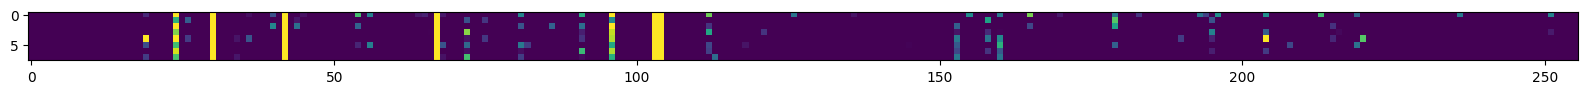

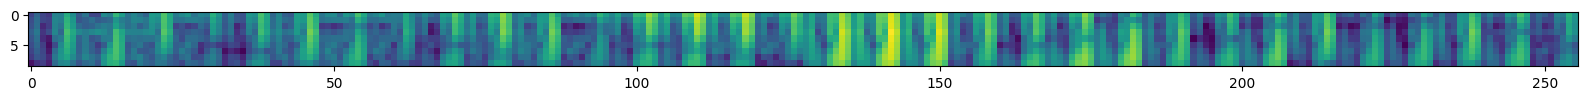

sample1 prob


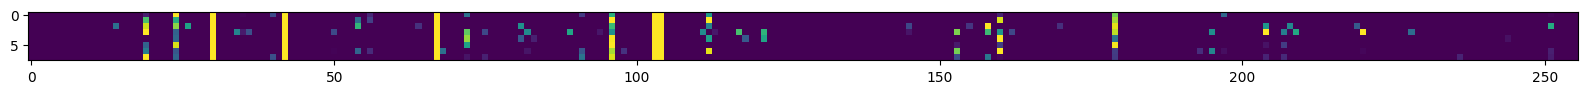

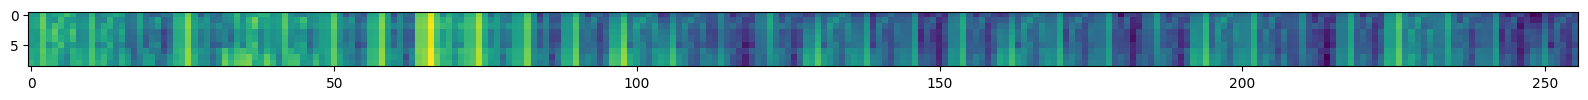

sample2 prob


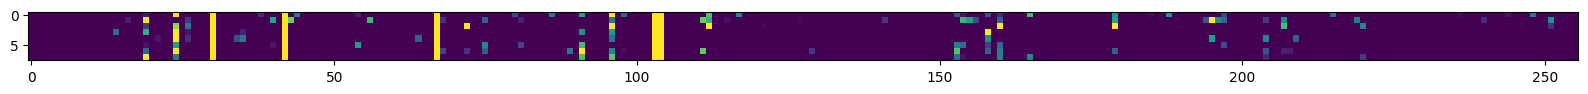

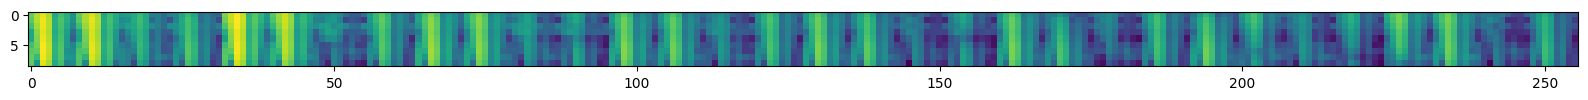

sample3 prob


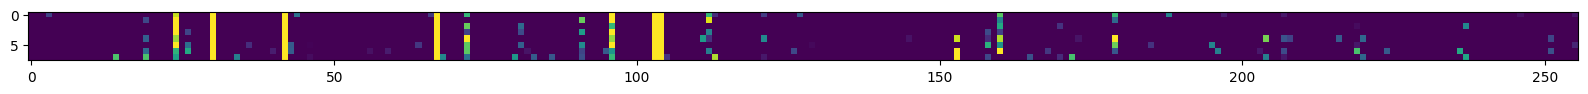

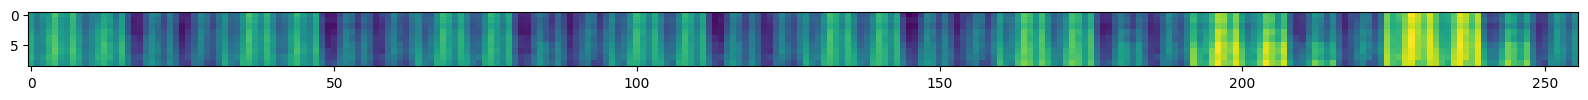

sample4 prob


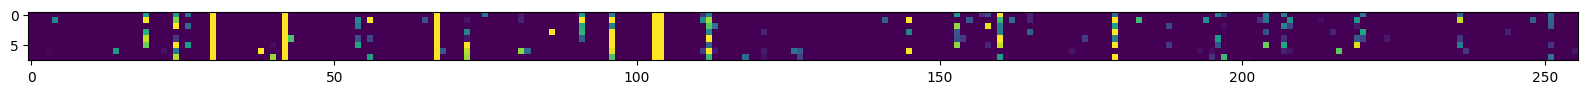

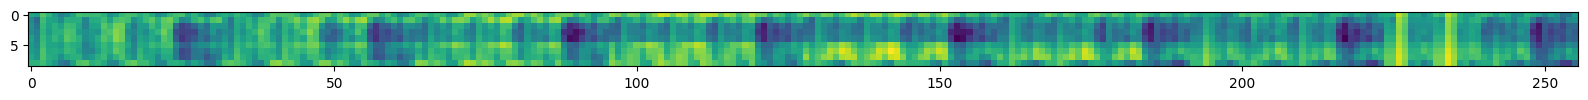

sample5 prob


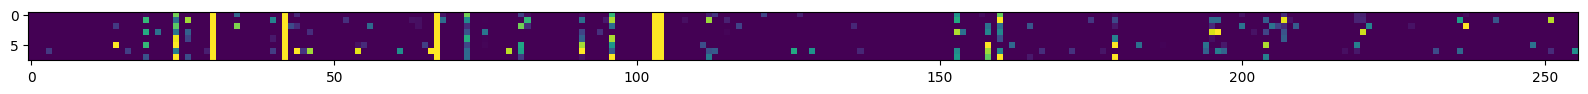

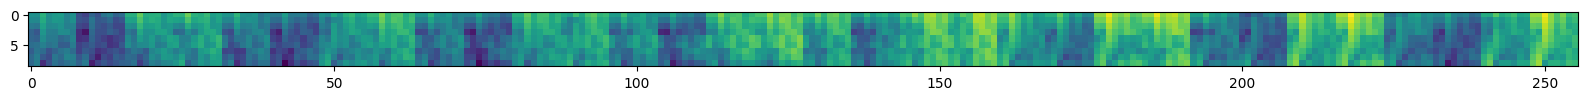

sample6 prob


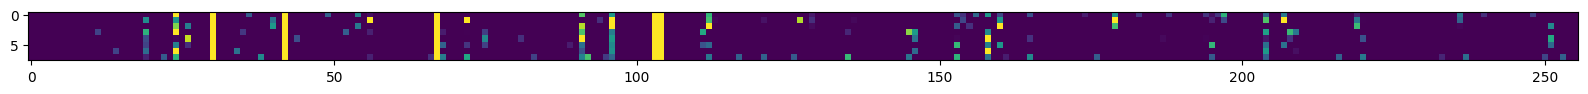

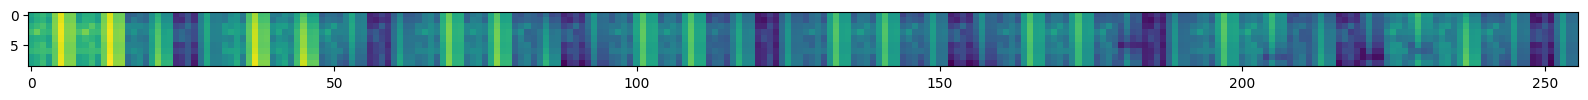

sample7 prob


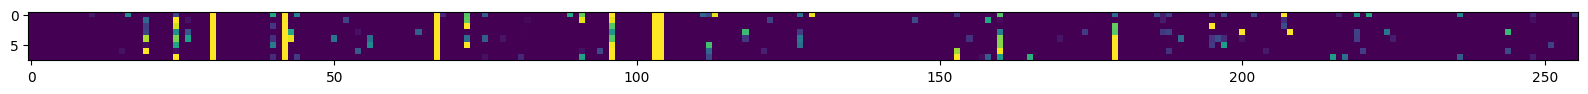

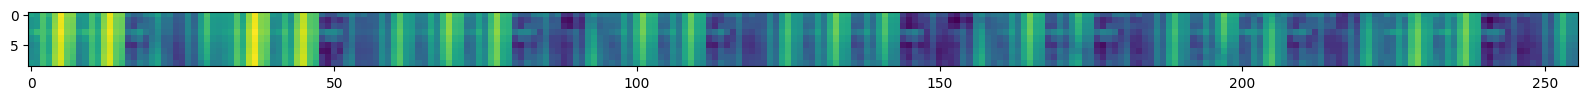

sample8 prob


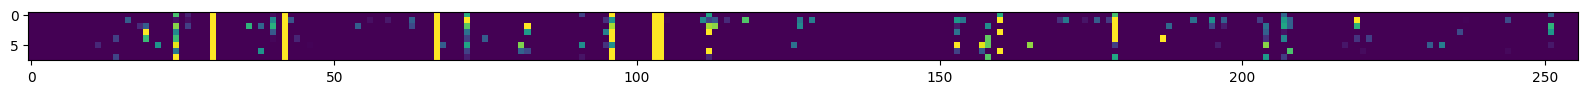

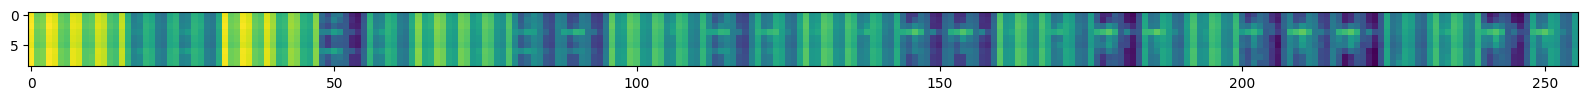

sample9 prob


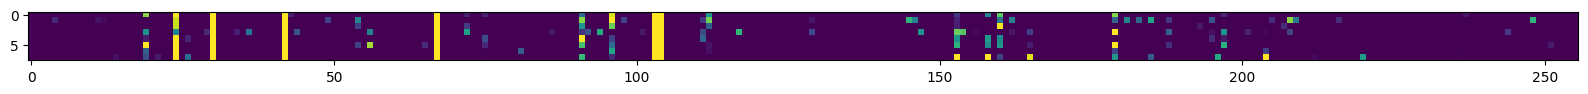

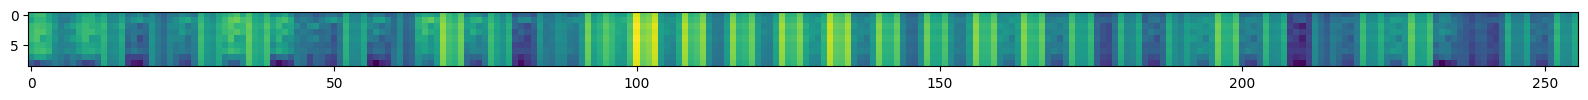

sample10 prob


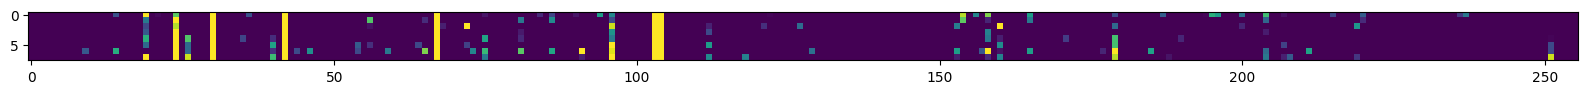

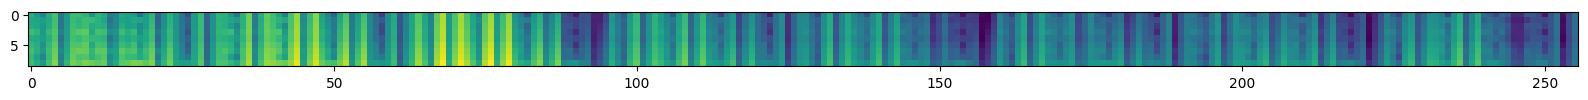

sample11 prob


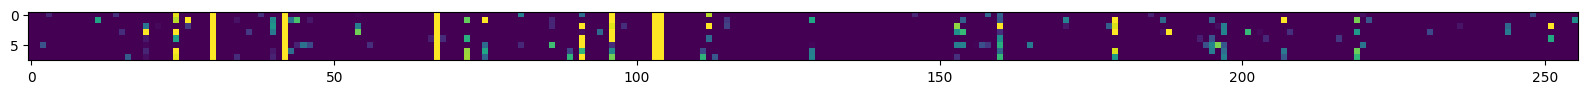

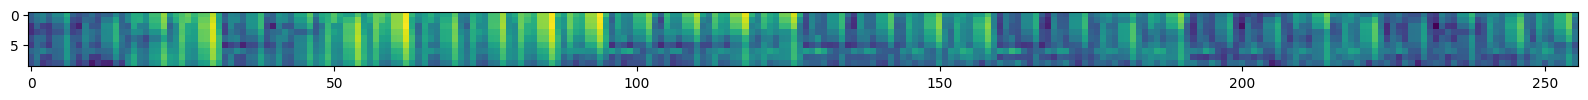

sample12 prob


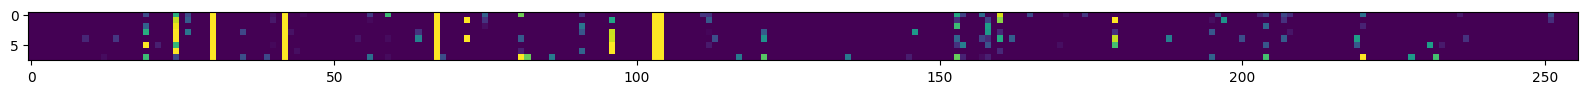

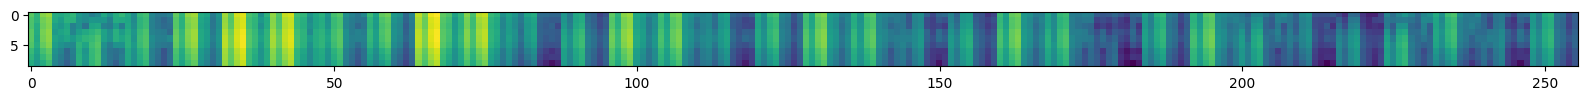

sample13 prob


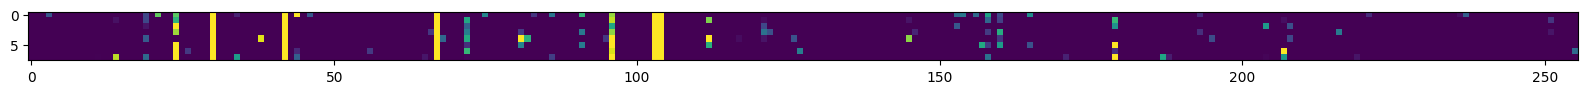

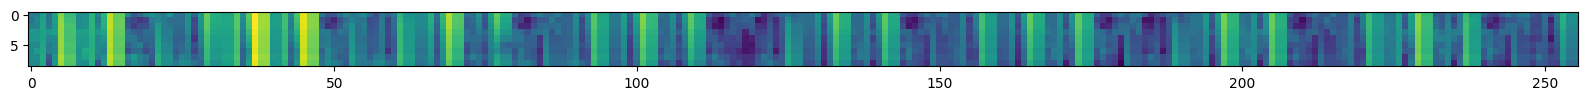

sample14 prob


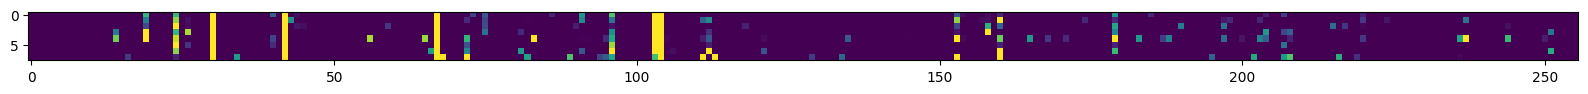

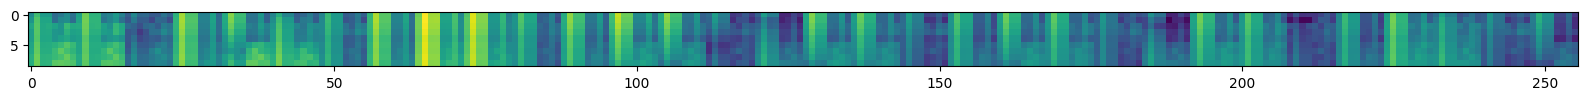

sample15 prob


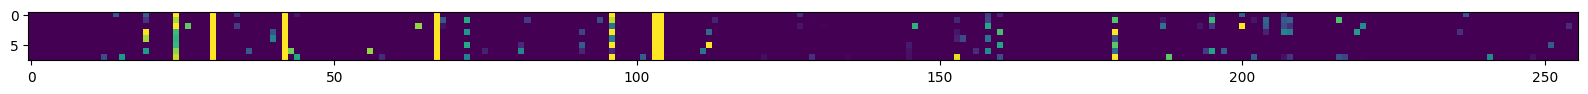

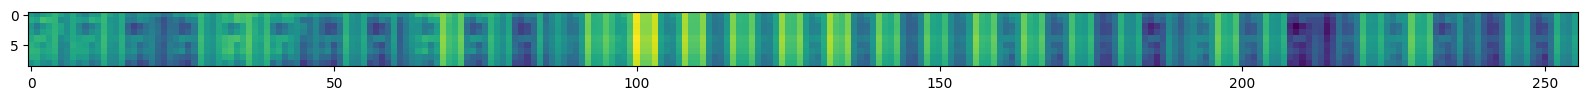

sample16 prob


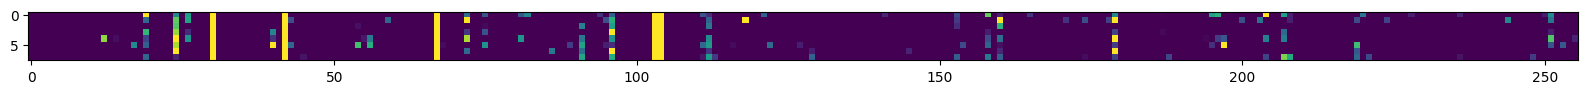

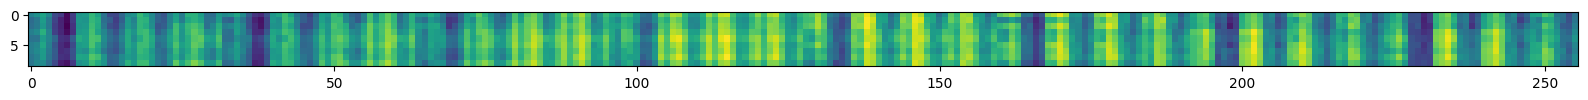

sample17 prob


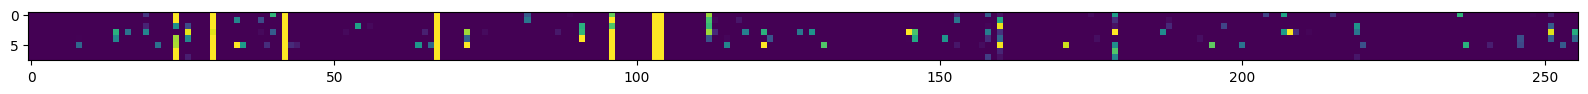

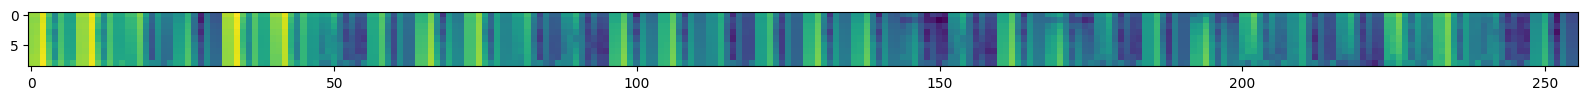

sample18 prob


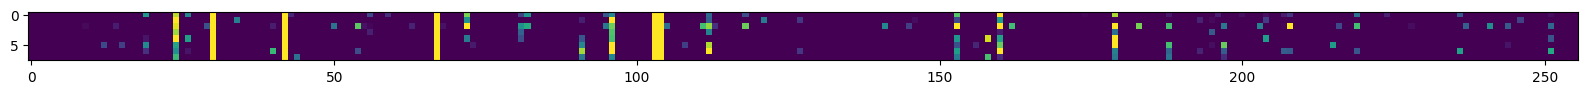

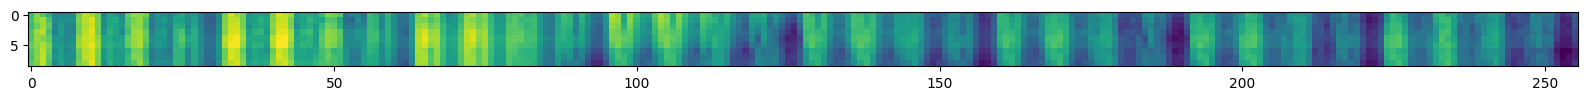

sample19 prob


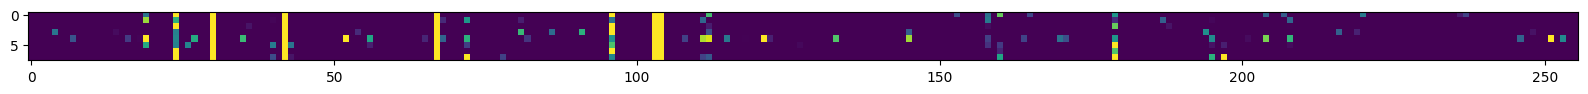

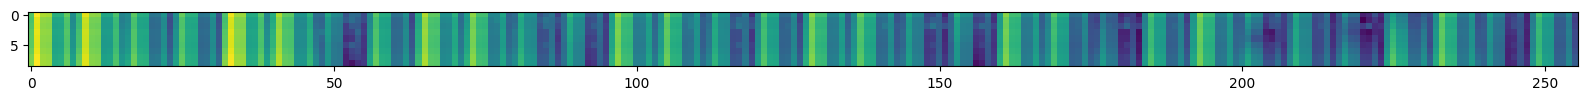

sample20 prob


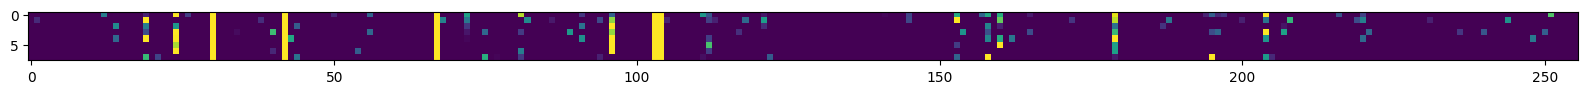

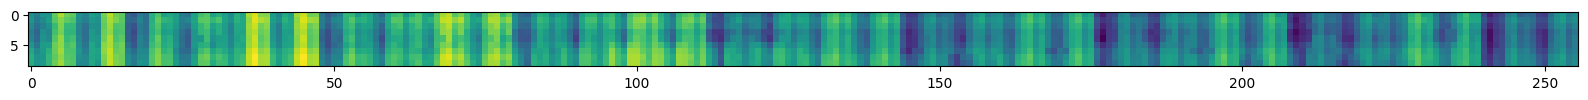

sample21 prob


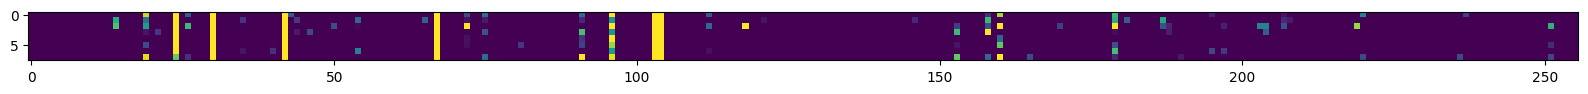

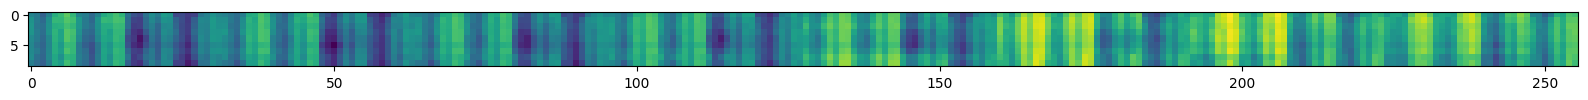

sample22 prob


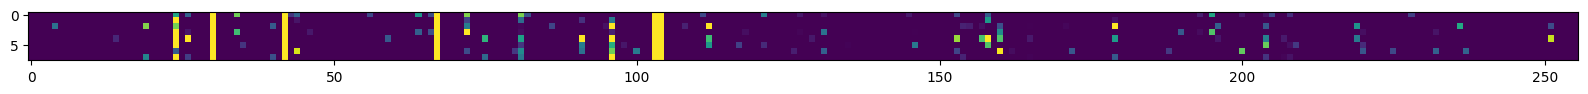

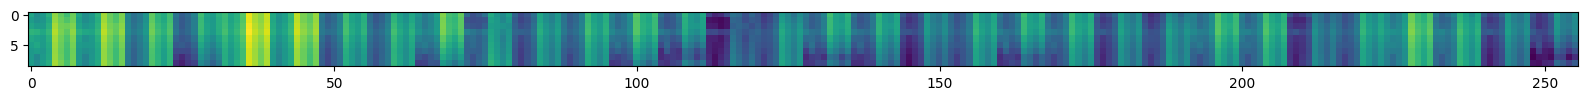

sample23 prob


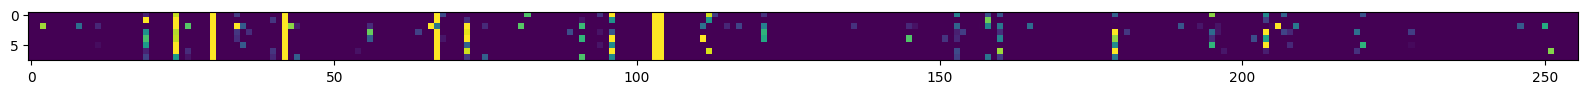

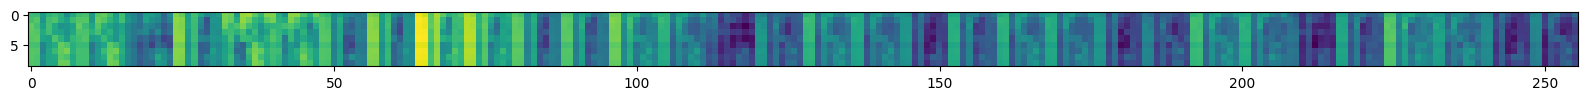

sample24 prob


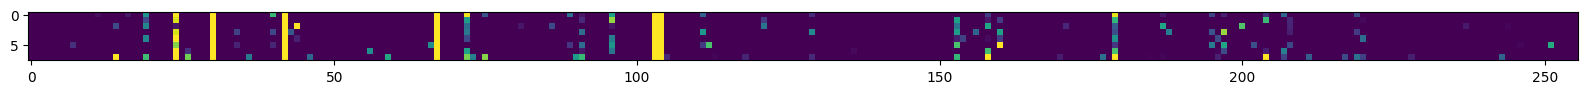

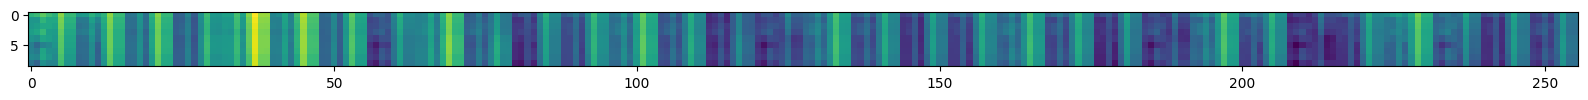

sample25 prob


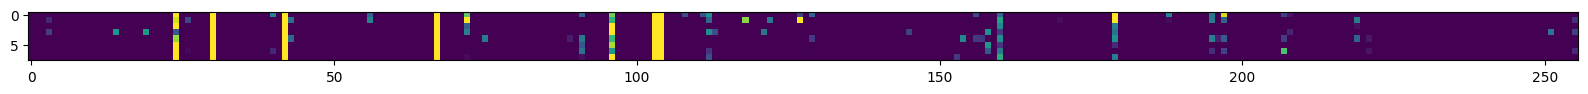

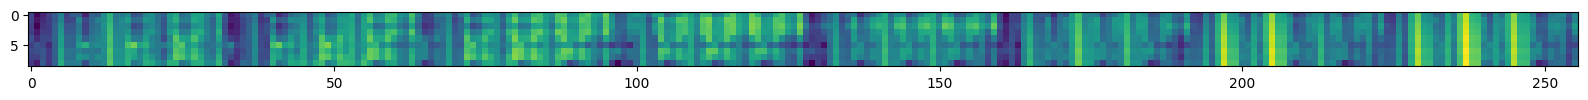

sample26 prob


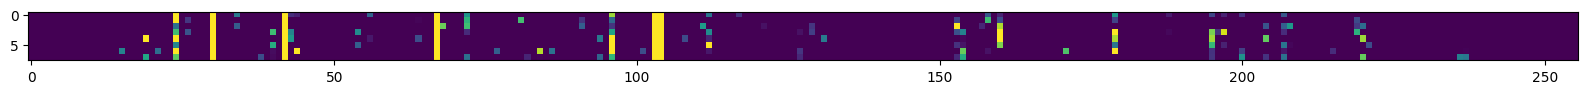

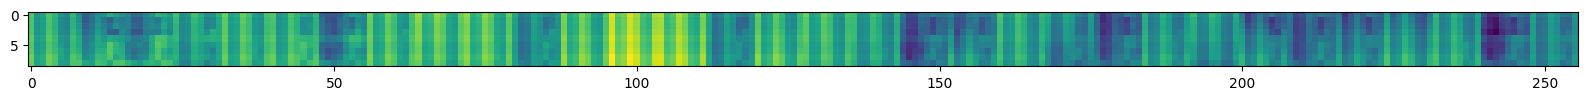

sample27 prob


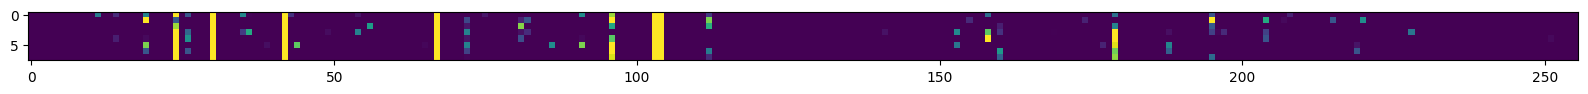

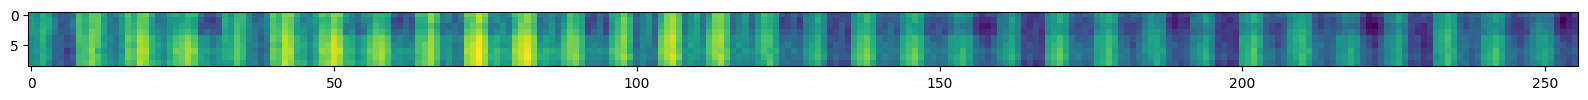

sample28 prob


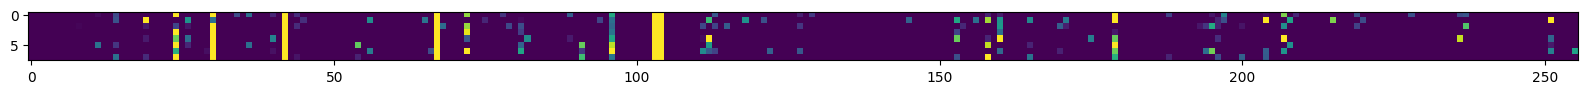

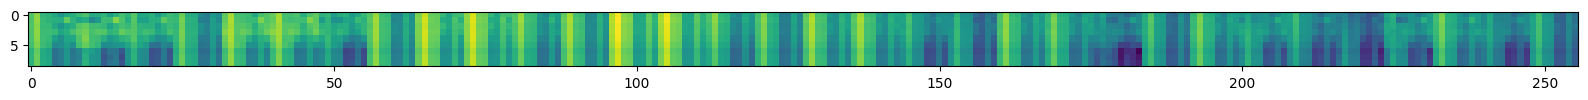

sample29 prob


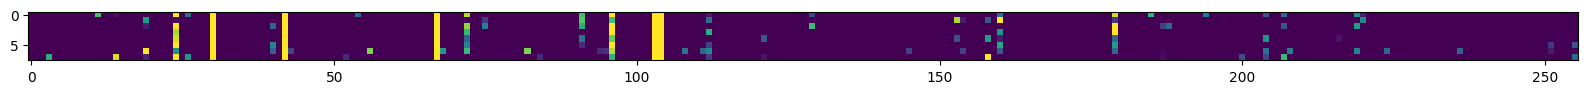

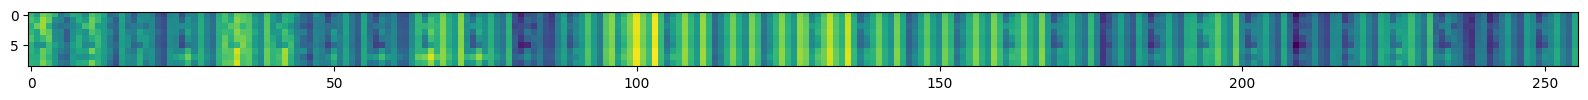

sample30 prob


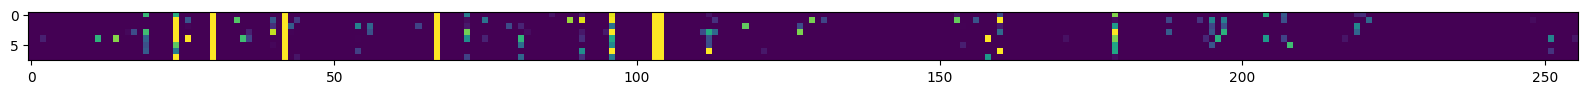

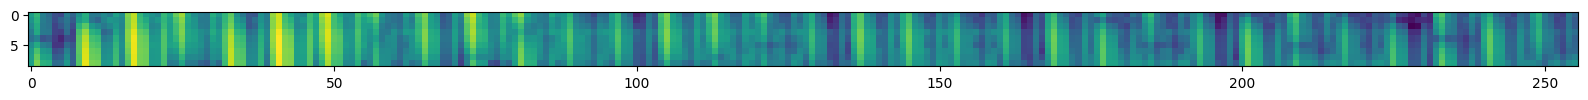

sample31 prob


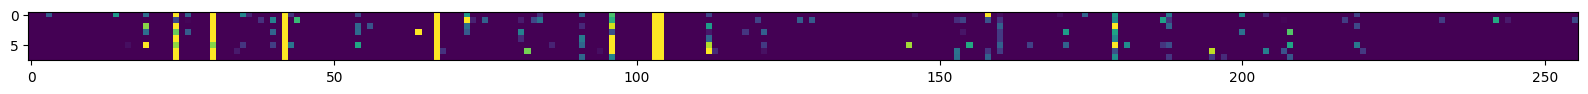

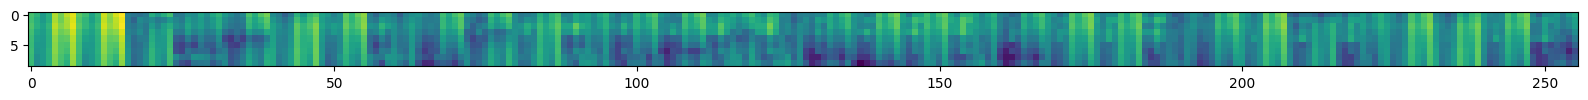

sample32 prob


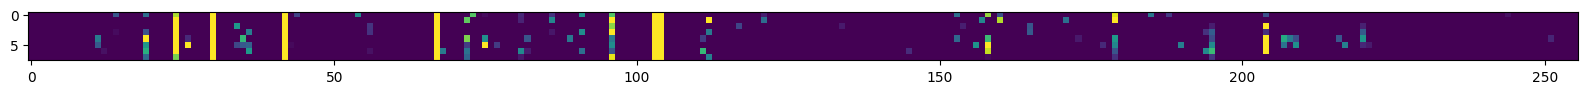

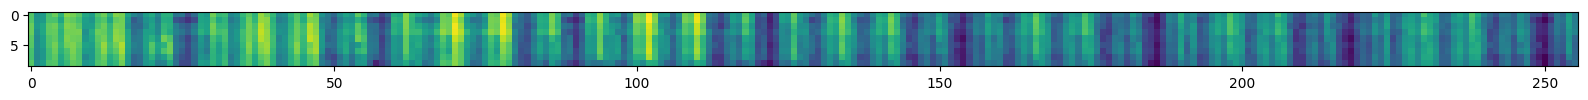

sample33 prob


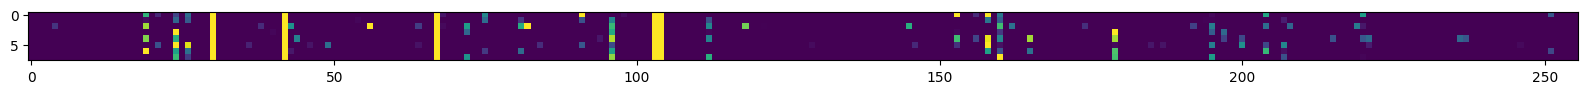

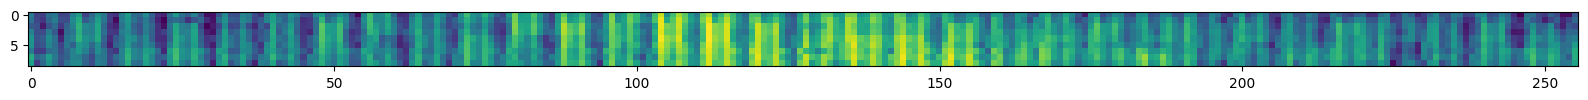

sample34 prob


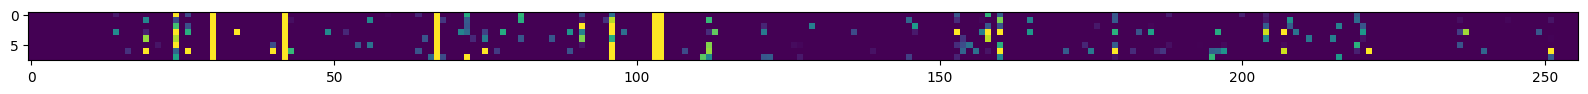

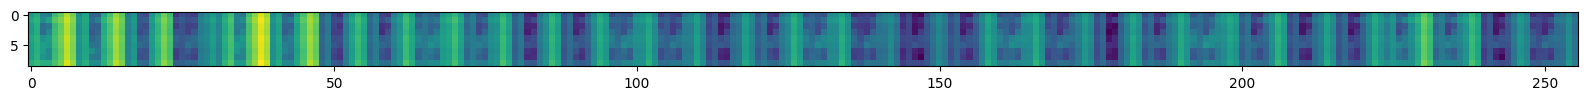

sample35 prob


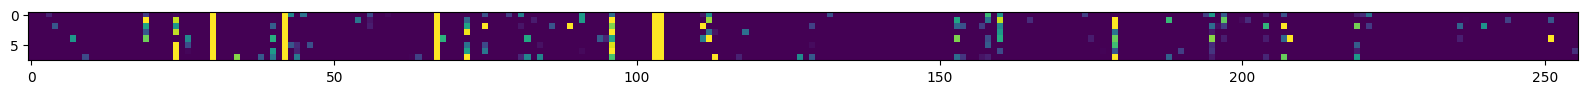

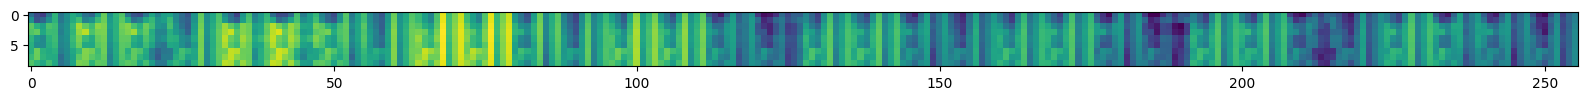

sample36 prob


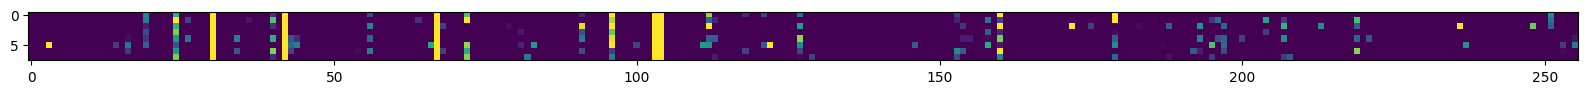

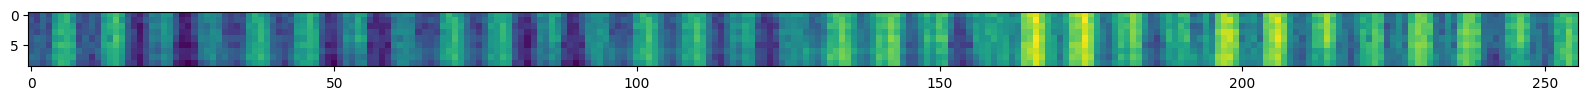

sample37 prob


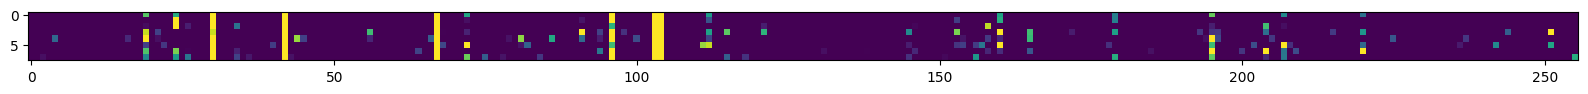

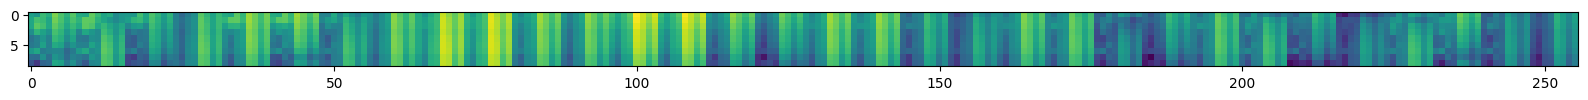

sample38 prob


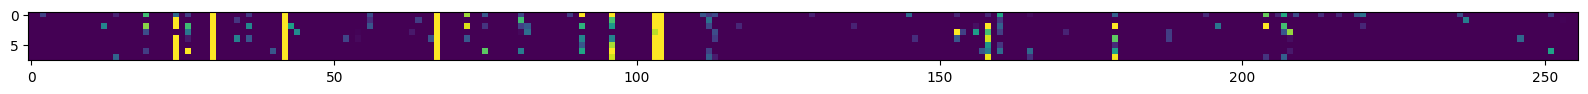

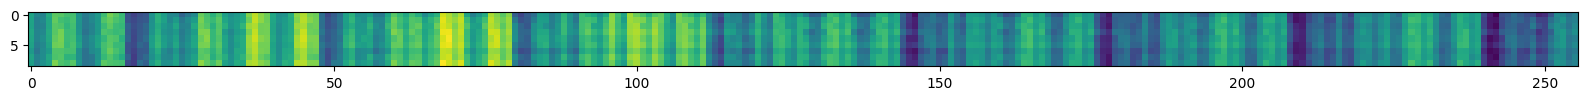

sample39 prob


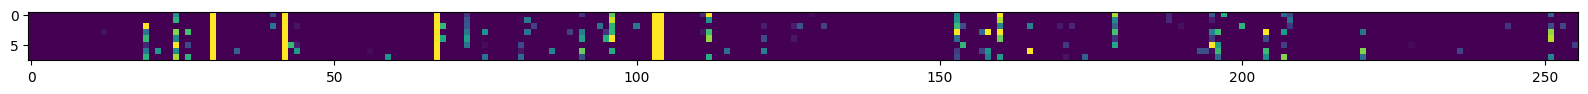

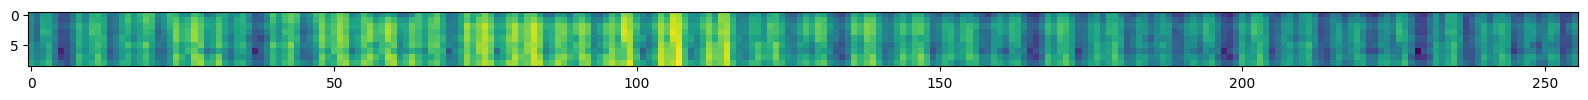

sample40 prob


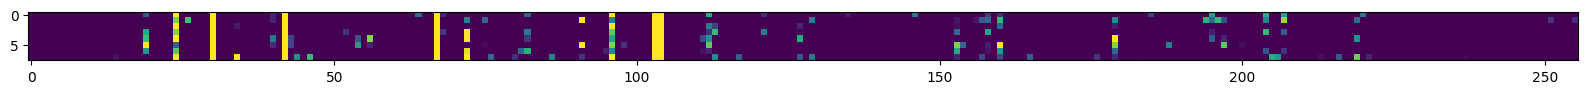

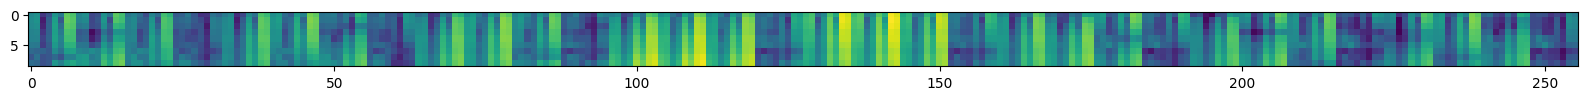

sample41 prob


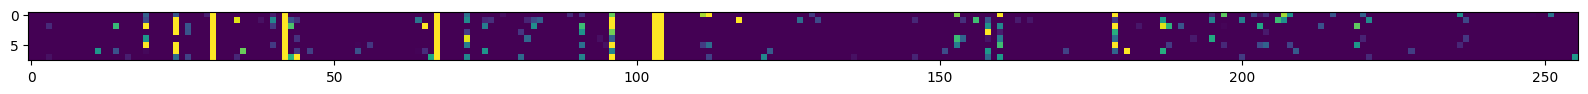

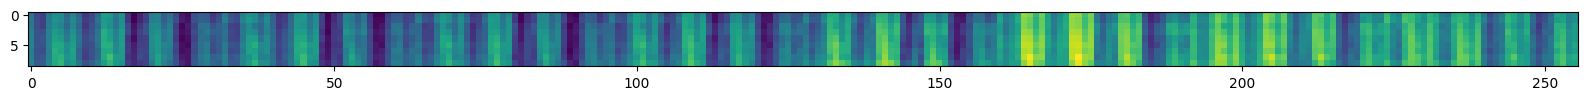

sample42 prob


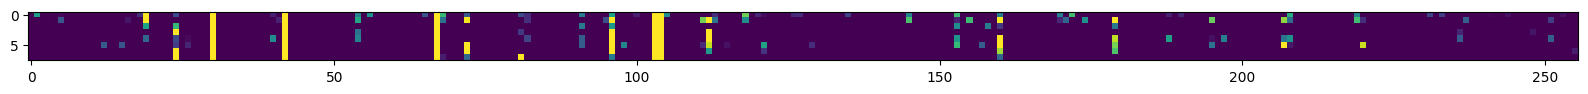

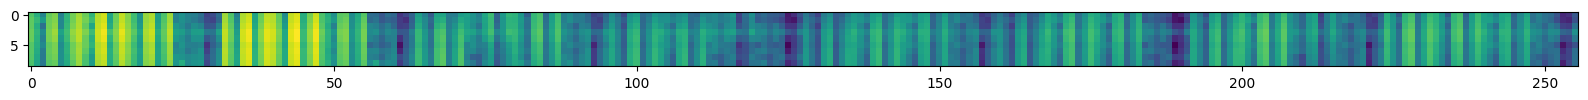

sample43 prob


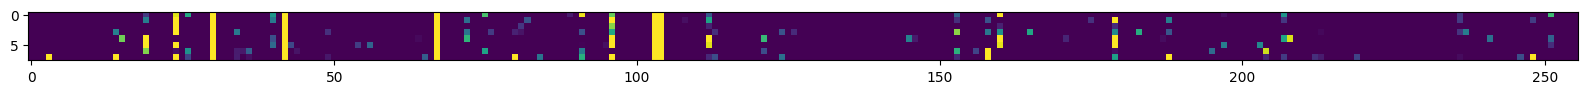

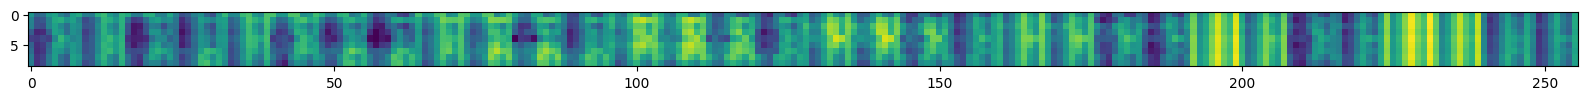

sample44 prob


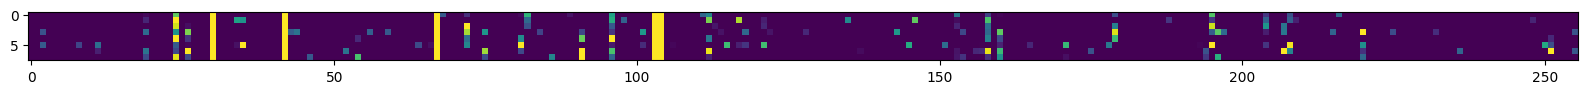

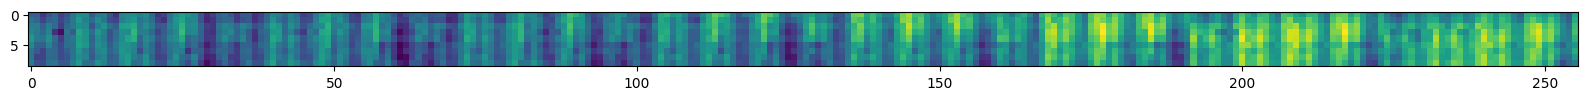

sample45 prob


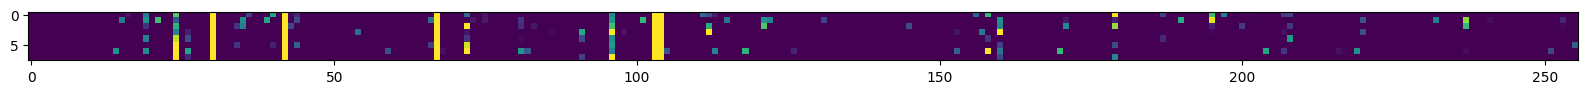

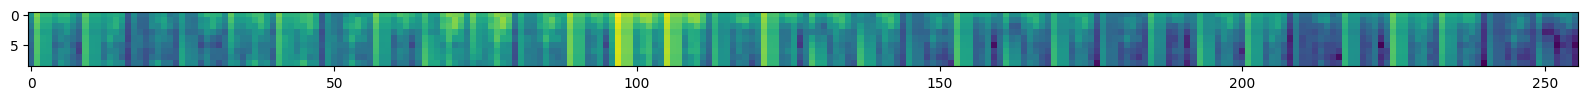

sample46 prob


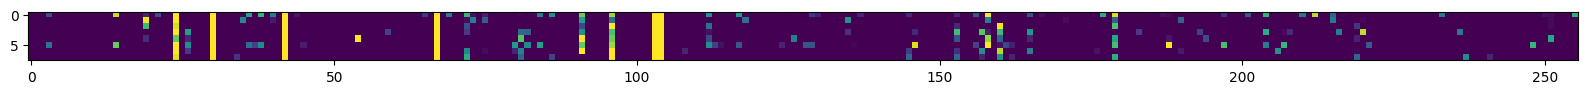

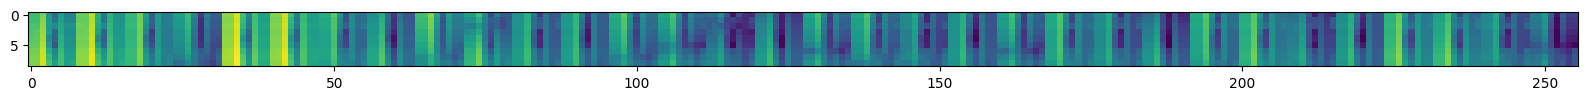

sample47 prob


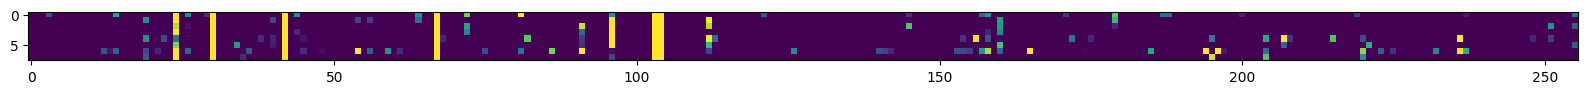

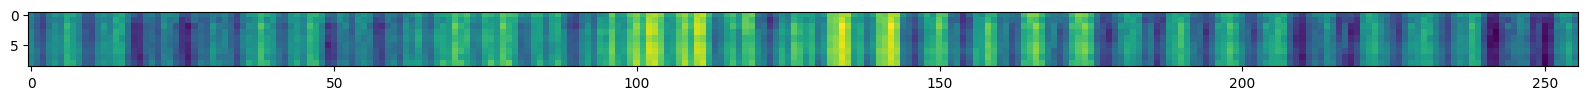

sample48 prob


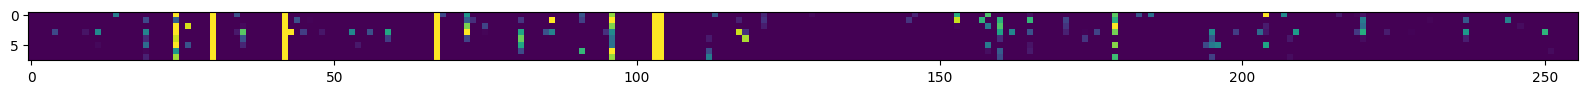

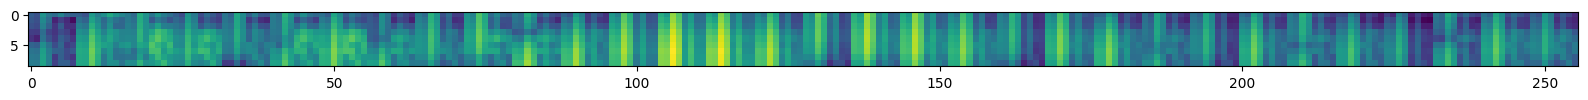

sample49 prob


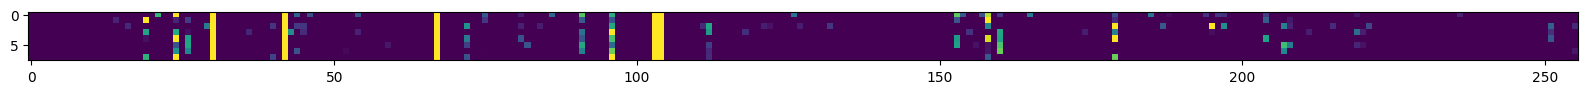

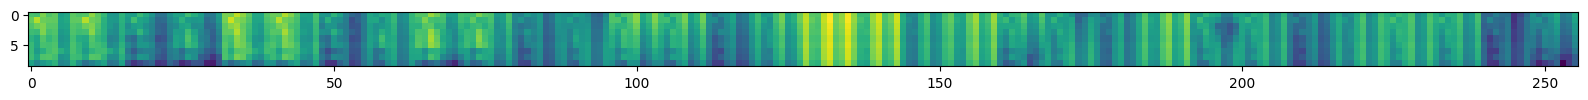

In [24]:
import matplotlib.pyplot as plt 

for k in range(50):
    print('sample{} prob'.format(k))
    plt.figure(figsize=(20,5))
    plt.imshow(probs_[k])
    plt.show()
    plt.figure(figsize=(20,5))
    plt.imshow(inputs[k])
    plt.show()

# for k in range(3):
#     print('sample{} mask + random gaussian noise'.format(k))
#     plt.figure(figsize=(20,5))
#     plt.imshow(masks[k])
#     plt.show()

In [25]:
# for i in range(3):
#     sns.heatmap(probs_[i*50, :, :].transpose(1,0))
#     plt.title(f'Dynamic probs sample {i}')
#     plt.xlabel('time')
#     plt.ylabel('txrx')
#     plt.show()

# for i in range(3):
#     sns.heatmap(masks[i*50, :, :].transpose(1,0))
#     plt.title(f'Dynamic mask sample {i}')
#     plt.xlabel('time')
#     plt.ylabel('txrx')
#     plt.show()

In [26]:
# st = 150
# ed = 200

# for i in range(10):
#     sns.heatmap(masks[i*50, :, st:ed].transpose(1,0))
#     plt.title(f'Dynamic mask sample {i}')
#     plt.xlabel('time')
#     plt.ylabel('txrx')
#     plt.show()

In [27]:
np.round(len(np.where(masks != 1)[0]) / len(masks.reshape(-1)) , 3)

0.967